In [ ]:
from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt
import dpdata
import glob
import seaborn as sns
import pandas as pd
import os
from dpeva.sampling.direct import BirchClustering, DIRECTSampler, SelectKFromClusters

In [ ]:
# load data (not upload now)
desc_string = 'descriptors/*/desc.npy'
dpdata_path = "./data-v2-7-20873-npy"
dpdata_string = "O*"

In [ ]:
# read descriptors/*/desc.npy data
print("Reading descriptor results...")
desc_names = []
desc_keys = []
desc_stru = []
desc_perstru = []
iter_list = sorted(glob.glob(desc_string))
for f in iter_list:
    # extract dirname of desc.npy from descriptors/*
    directory, _ = os.path.split(f)
    _, keyname = os.path.split(directory)
    desc_names.append(keyname)
    one_desc = np.load(f) # nframe, natoms, ndesc
    for ind in range(len(one_desc)):
        desc_keys.append(f"{keyname}-{ind}")
        desc_perstru.append(one_desc[ind])
    # do average in natoms dimension
    one_desc_stru = np.mean(one_desc, axis=1)
    desc_stru.append(one_desc_stru)
desc_stru = np.concatenate(desc_stru, axis=0)
np.shape(desc_stru)

Reading descriptor results...


(20873, 136)

In [7]:
# read dpdata for element type information 
#print("Reading corresponding dpdata...")
alldata =  dpdata.MultiSystems.from_dir(dpdata_path, dpdata_string, fmt="deepmd/npy")
alldata

/home/james/apps/miniconda3/envs/matpes/lib/python3.11/site-packages/dpdata/system.py:1106: UserWarning: Data type spins is registered twice; only the newly registered one will be used.
  warnings.warn(
/home/james/apps/miniconda3/envs/matpes/lib/python3.11/site-packages/dpdata/system.py:1106: UserWarning: Data type force_mags is registered twice; only the newly registered one will be used.
  warnings.warn(


MultiSystems (694 systems containing 20873 frames)

In [ ]:
alldata_list = []
for lbsys in alldata:
    for sys in lbsys:
        alldata_list.append(sys)

## plot structural and atomic feature space
In the MatPES manuscript, the 2-DIRECT method is aiming to choose the STRU with minimum number of atoms in the mixture of unitcell and supercell trajectory, while add supercell when necessary (having unique atomic features).

So, the most important thing is the dealing with atomic features

### step 1: Partition 20,837 structures into 40 groups according to location in structural feature space

In [49]:
%%time
DIRECT_partitioner = DIRECTSampler(
    structure_encoder=None,
    clustering=BirchClustering(n=40, threshold_init=0.5),
    select_k_from_clusters=None,
)

CPU times: user 235 μs, sys: 18 μs, total: 253 μs
Wall time: 256 μs


In [50]:
%%time
DIRECT_partition = DIRECT_partitioner.fit_transform(desc_stru)

INFO:maml.sampling.pca:Selected first 16 PCs, explaining 91.26% variance
INFO:maml.sampling.clustering:BirchClustering with threshold_init=0.5 and n=40 gives 40 clusters.


CPU times: user 4.74 s, sys: 120 ms, total: 4.86 s
Wall time: 365 ms


#### Visualize the partition results

In [55]:
explained_variance = DIRECT_partitioner.pca.pca.explained_variance_
selected_PC_dim = len([e for e in explained_variance if e > 1])
DIRECT_partition["PCAfeatures_unweighted"] = DIRECT_partition["PCAfeatures"] / explained_variance[:selected_PC_dim]
all_features = DIRECT_partition["PCAfeatures_unweighted"]

<Axes: xlabel='pc1', ylabel='pc2'>

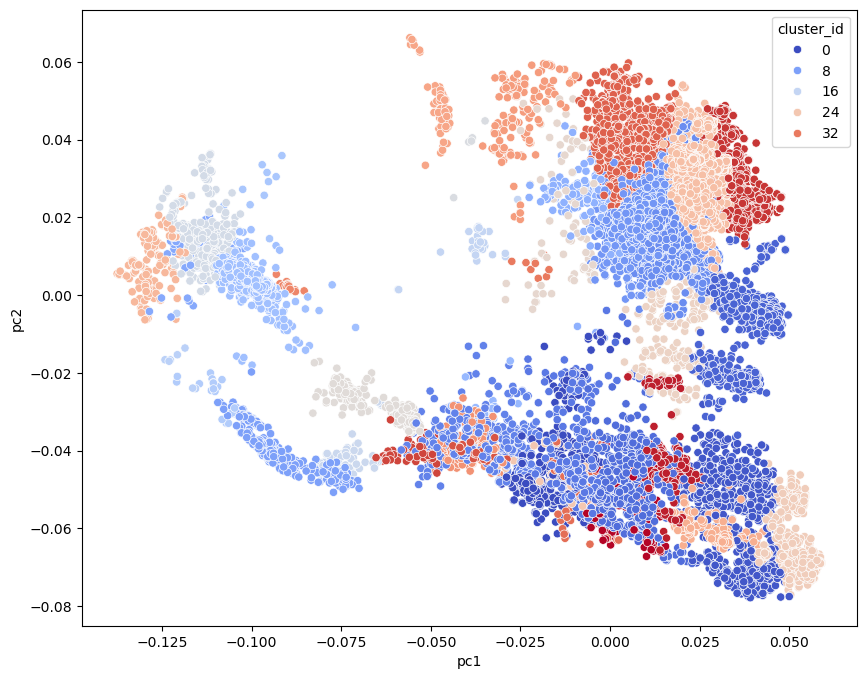

In [91]:
df_partition = pd.DataFrame(
    {
        "pc1": all_features[:, 0],
        "pc2": all_features[:, 1],
        "cluster_id": DIRECT_partition["labels"],
        "sys_name": desc_keys
    }
)

plt.figure(figsize=(10, 8))
sns.scatterplot(df_partition, 
                x="pc1", 
                y="pc2", 
                hue="cluster_id", 
                palette="coolwarm")

### Step 2: DIRECT sampling 100 structures from each cluster according to atomic features and structure size

In [ ]:
%%time
# most important part
sampled_structure_ids = []
for label in set(DIRECT_partition["labels"]):
    # do cluster in struc_cluster based on atomic features and natoms
    structure_ids = np.where(DIRECT_partition["labels"]==label)[0]
    atom_features = [
        af for ind,afs in enumerate(
            desc_perstru
        ) if ind in structure_ids for af in afs
    ]
    # double for in list like the same double for extended
    natoms = [natom for ind,sys in enumerate(alldata_list) for natom in [sys.get_natoms()]*sys.get_natoms() if ind in structure_ids]
    structure_ids_atomf = [ind for ind,sys in enumerate(alldata_list) for natom in [sys.get_natoms()]*sys.get_natoms() if ind in structure_ids]
    
    assert len(atom_features) == len(natoms)
    assert len(structure_ids_atomf) == len(natoms)
    
    # select structures with smallest natoms based on atomic features
    direct_sampler = DIRECTSampler(None,
                                   clustering=BirchClustering(
                                       n = 100, 
                                       threshold_init = 0.1),
                                   select_k_from_clusters = SelectKFromClusters(
                                       k = 1,
                                       selection_criteria = "smallest", 
                                       n_sites = natoms
                                   )
                                  )   # prior to smallest structure to reduce computational cost
    DIRECT_sampling = direct_sampler.fit_transform(np.array(atom_features))
    struct_ids = list(set([structure_ids_atomf[ind] for ind in DIRECT_sampling["selected_indices"]]))
    sampled_structure_ids.extend(struct_ids)
sampled_structure_ids = list(set(sampled_structure_ids))
print(f"Selected in total {len(sampled_structure_ids)} smallest possible structures with 2DIRECT")

INFO:maml.sampling.pca:Selected first 16 PCs, explaining 88.91% variance
INFO:maml.sampling.clustering:BirchClustering with threshold_init=0.1 and n=100 gives 100 clusters.
INFO:maml.sampling.stratified_sampling:Finally selected 100 configurations.
INFO:maml.sampling.pca:Selected first 15 PCs, explaining 89.81% variance
INFO:maml.sampling.clustering:BirchClustering with threshold_init=0.1 and n=100 gives 100 clusters.
INFO:maml.sampling.stratified_sampling:Finally selected 100 configurations.
INFO:maml.sampling.pca:Selected first 14 PCs, explaining 88.95% variance
INFO:maml.sampling.clustering:BirchClustering with threshold_init=0.1 and n=100 gives 100 clusters.
INFO:maml.sampling.stratified_sampling:Finally selected 100 configurations.
INFO:maml.sampling.pca:Selected first 17 PCs, explaining 87.93% variance
INFO:maml.sampling.clustering:BirchClustering with threshold_init=0.1 and n=100 gives 100 clusters.
INFO:maml.sampling.stratified_sampling:Finally selected 100 configurations.
INFO

Selected in total 1693 smallest possible structures with 2DIRECT
CPU times: user 9min 18s, sys: 45.2 s, total: 10min 3s
Wall time: 4min 26s


In [67]:
from copy import deepcopy
sampled_stru_ids_mini_natom = deepcopy(sampled_structure_ids)

In [ ]:
%%time
# most important part
sampled_structure_ids = []
for label in set(DIRECT_partition["labels"]):
    # do cluster in struc_cluster based on atomic features and natoms
    structure_ids = np.where(DIRECT_partition["labels"]==label)[0]
    atom_features = [
        af for ind,afs in enumerate(
            desc_perstru
        ) if ind in structure_ids for af in afs
    ]
    # double for in list like the same double for extended
    natoms = [natom for ind,sys in enumerate(alldata_list) for natom in [sys.get_natoms()]*sys.get_natoms() if ind in structure_ids]
    structure_ids_atomf = [ind for ind,sys in enumerate(alldata_list) for natom in [sys.get_natoms()]*sys.get_natoms() if ind in structure_ids]
    
    assert len(atom_features) == len(natoms)
    assert len(structure_ids_atomf) == len(natoms)
    
    # select structures with smallest natoms based on atomic features
    direct_sampler = DIRECTSampler(None,
                                   clustering=BirchClustering(
                                       n = 100, 
                                       threshold_init = 0.1),
                                   select_k_from_clusters = SelectKFromClusters(
                                       k = 1,
                                       selection_criteria = "center", 
                                       n_sites = natoms
                                   )
                                  )   # try to use to center of cluster
    DIRECT_sampling = direct_sampler.fit_transform(np.array(atom_features))
    struct_ids = list(set([structure_ids_atomf[ind] for ind in DIRECT_sampling["selected_indices"]]))
    sampled_structure_ids.extend(struct_ids)
sampled_structure_ids = list(set(sampled_structure_ids))
print(f"Selected in total {len(sampled_structure_ids)} smallest possible structures with 2DIRECT")

INFO:maml.sampling.pca:Selected first 16 PCs, explaining 88.91% variance
INFO:maml.sampling.clustering:BirchClustering with threshold_init=0.1 and n=100 gives 100 clusters.
INFO:maml.sampling.stratified_sampling:Finally selected 100 configurations.
INFO:maml.sampling.pca:Selected first 15 PCs, explaining 89.81% variance
INFO:maml.sampling.clustering:BirchClustering with threshold_init=0.1 and n=100 gives 100 clusters.
INFO:maml.sampling.stratified_sampling:Finally selected 100 configurations.
INFO:maml.sampling.pca:Selected first 14 PCs, explaining 88.95% variance
INFO:maml.sampling.clustering:BirchClustering with threshold_init=0.1 and n=100 gives 100 clusters.
INFO:maml.sampling.stratified_sampling:Finally selected 100 configurations.
INFO:maml.sampling.pca:Selected first 17 PCs, explaining 87.93% variance
INFO:maml.sampling.clustering:BirchClustering with threshold_init=0.1 and n=100 gives 100 clusters.
INFO:maml.sampling.stratified_sampling:Finally selected 100 configurations.
INFO

Selected in total 2256 smallest possible structures with 2DIRECT
CPU times: user 9min 39s, sys: 22.7 s, total: 10min 1s
Wall time: 4min 23s


In [69]:
sampled_stru_ids_center = deepcopy(sampled_structure_ids)

In [ ]:
def plot_feature_coverage(selected_indices,
                          all_structures,
                          all_features,
                          all_features_atoms,
                          method="2DIRECT"):
    fig, ax = plt.subplots(figsize=(10, 8))
    selected_features = all_features[selected_indices]
    ave_all = round(np.mean([s.get_natoms() for s in all_structures]))
    ave_selected = round(np.mean([s.get_natoms() for i,s in enumerate(all_structures) if i in selected_indices]))
    
    # do PCA on all_features and all_features_atoms
    
    
    plt.plot(all_features[:, 0], all_features[:, 1], "*", alpha=0.5,
             label=f"All {len(all_features):,} structures, nsite$_{{ave}}$={ave_all}")
    plt.plot(
        selected_features[:, 0],
        selected_features[:, 1],
        "*",
        alpha=0.5,
        label=f"{method} sampled {len(selected_features):,} structures, nsite$_{{ave}}$={ave_selected}",
    )
    plt.legend(frameon=False, fontsize=12, reverse=False)
    plt.xlabel("1st dimension", fontsize=14)
    plt.ylabel("2nd dimension", fontsize=14)
    plt.title("DPA-2 structural feature", fontsize=18)
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 8))
    all_features_atoms_flatten = np.array([af for afs in all_features_atoms for af in afs])
    atom_features_atom_selected_flatten = np.array([
        af for i,afs in enumerate(all_features_atoms) if i in selected_indices for af in afs])
    plt.plot(
    all_features_atoms_flatten[:, 0], all_features_atoms_flatten[:, 1], "*",
    alpha=0.5, label=f"All {len(all_features_atoms_flatten):,} atomic environments"
    )
    plt.plot(
    atom_features_atom_selected_flatten[:, 0], atom_features_atom_selected_flatten[:, 1], "*",
    alpha=0.5, label=f"{method} selected {len(atom_features_atom_selected_flatten):,}"
)
    plt.legend(frameon=False, fontsize=12, reverse=False)
    plt.xlabel("1st dimension", fontsize=14)
    plt.ylabel("2nd dimension", fontsize=14)
    plt.title("DPA-2 atomic feature", fontsize=18)

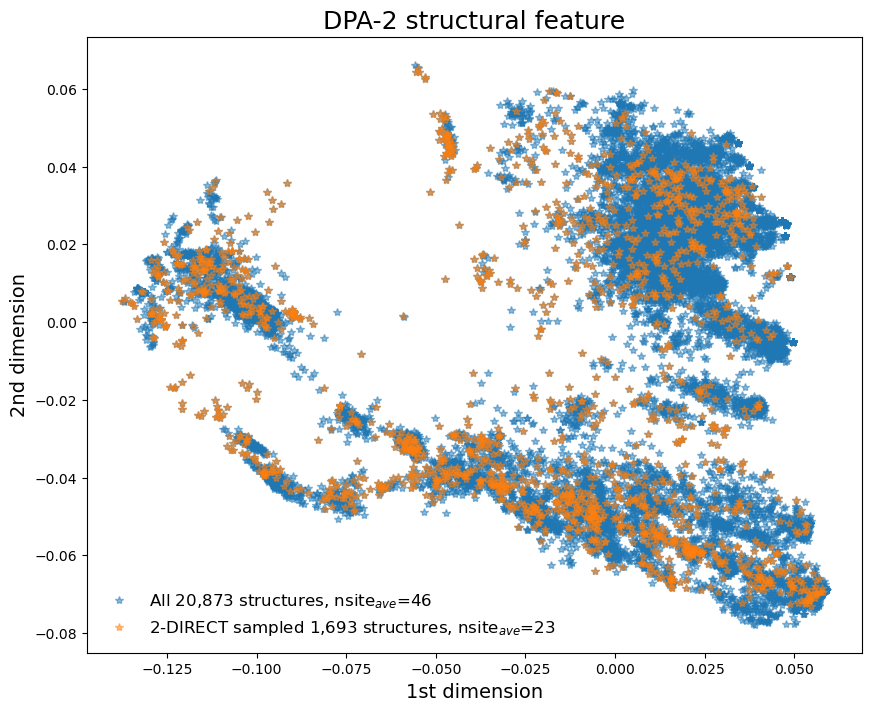

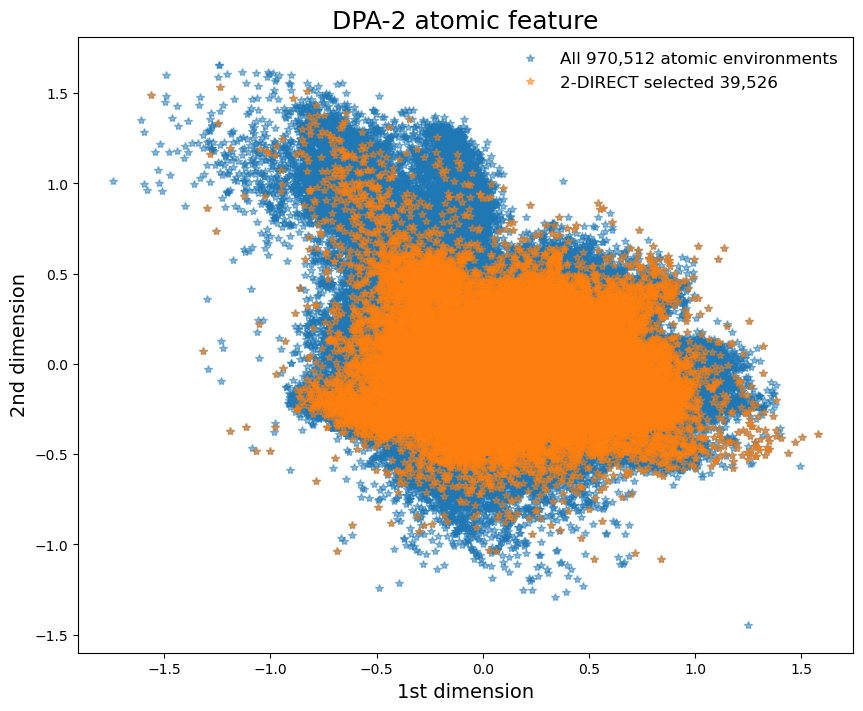

In [93]:
plot_feature_coverage(
    sampled_stru_ids_mini_natom,
    all_structures=alldata_list,
    all_features=DIRECT_partition["PCAfeatures_unweighted"],
    all_features_atoms=desc_perstru,
    method="2-DIRECT"
    )

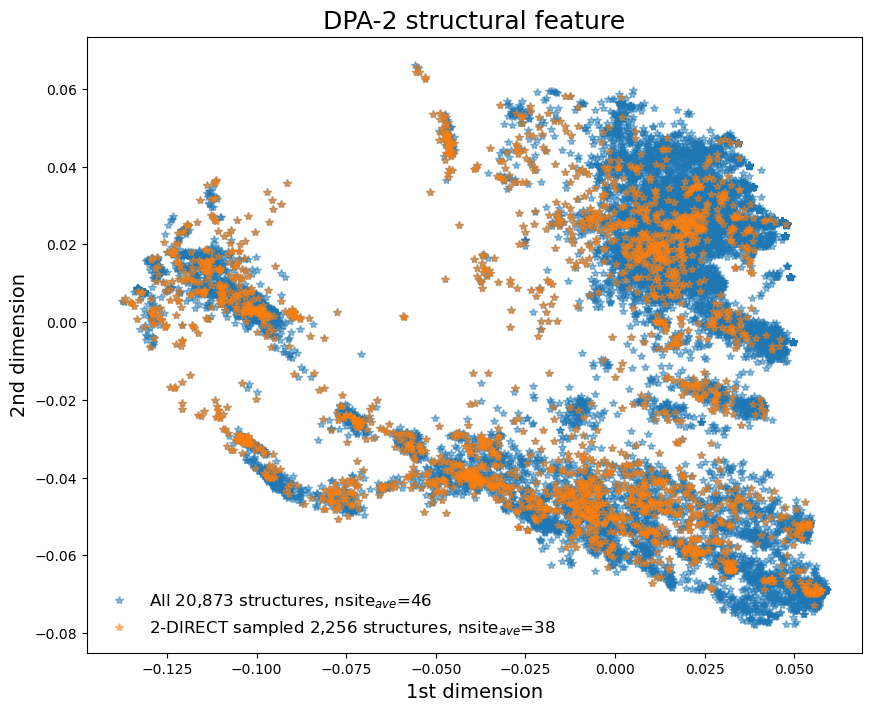

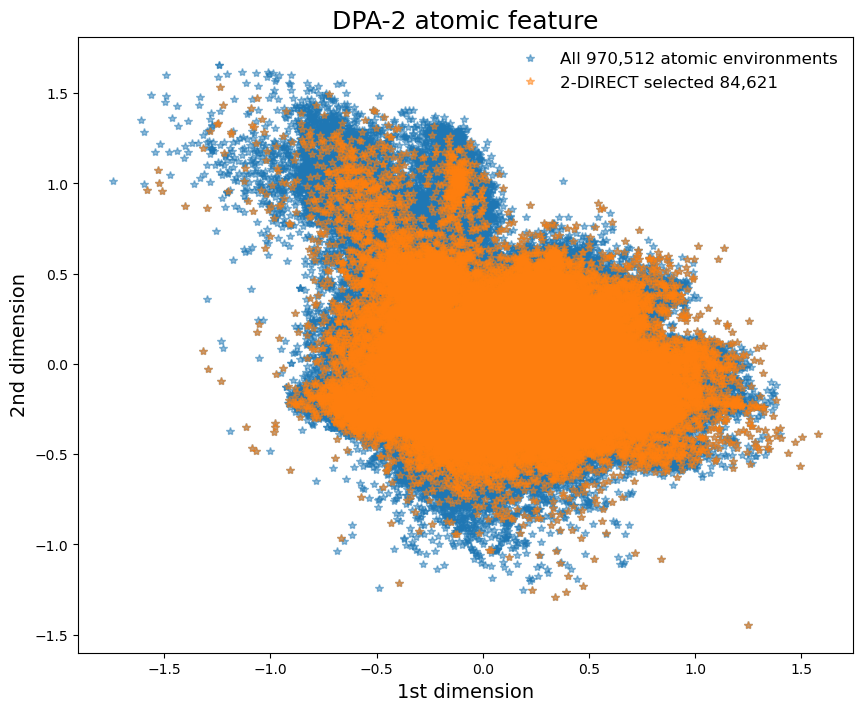

In [94]:
plot_feature_coverage(
    sampled_stru_ids_center,
    all_structures=alldata_list,
    all_features=DIRECT_partition["PCAfeatures_unweighted"],
    all_features_atoms=desc_perstru,
    method="2-DIRECT"
    )

In [ ]:
%%time
# comparision
direct_original = DIRECTSampler(None, clustering=BirchClustering(n=2000, threshold_init=0.1))
DIRECT_original = direct_original.fit_transform(desc_stru)
sampled_structure_ids_original = DIRECT_original["selected_indices"]

INFO:maml.sampling.pca:Selected first 16 PCs, explaining 91.26% variance
/home/james/apps/miniconda3/envs/matpes/lib/python3.11/site-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (1648) by BIRCH is less than (2000). Decrease the threshold.
  warnings.warn(
INFO:maml.sampling.clustering:BirchClustering with threshold_init=0.1 and n=2000 gives 1648 clusters.
INFO:maml.sampling.clustering:BirchClustering with threshold_init=0.0824 and n=2000 gives 2000 clusters.
INFO:maml.sampling.stratified_sampling:Finally selected 2000 configurations.


CPU times: user 6.75 s, sys: 45.8 ms, total: 6.79 s
Wall time: 1.29 s


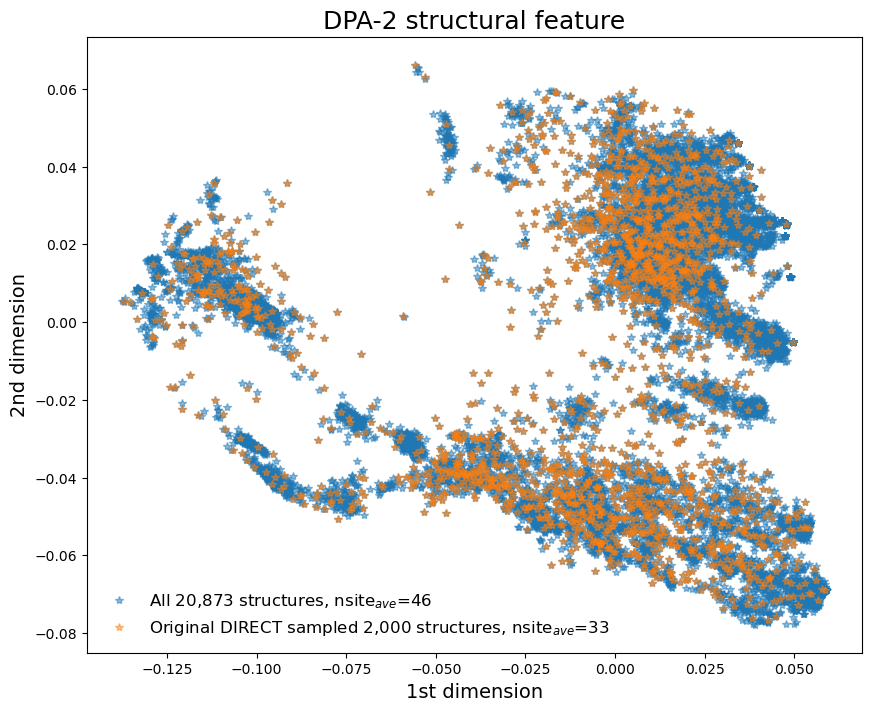

CPU times: user 3.23 s, sys: 350 ms, total: 3.58 s
Wall time: 3.58 s


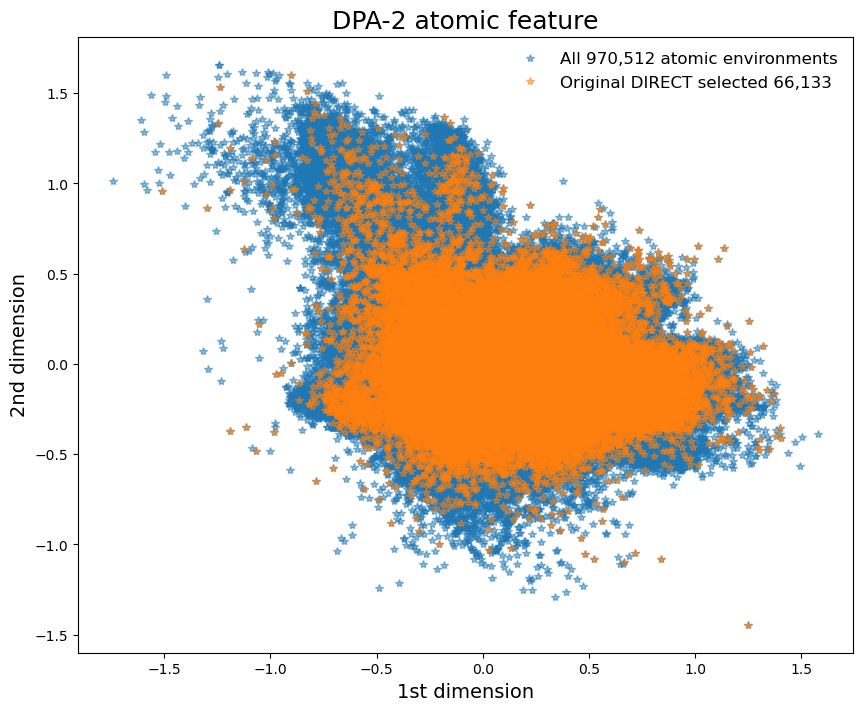

In [95]:
%%time
plot_feature_coverage(sampled_structure_ids_original, 
                      alldata_list,
                      DIRECT_partition["PCAfeatures_unweighted"],
                      desc_perstru,
                      method="Original DIRECT")